In [1]:
color_line_1 = 'royalblue'
color_line_2 = 'red'
color_scatter_1 = 'black' #'darkslategrey' #darkred

# Cubic Hermitian Spline

In [2]:
import torch

def compute_cubic_spline(parameters: torch.Tensor, step: int, horizon: int):
    """ Given a set of spline parameters, and the point in the trajectory return the function value 
    
    Args :
        parameters (Tensor): Spline action parameter      of shape(batch, num_legs, 3, spline_param)              
        step          (int): The point in the curve in [0, horizon]
        horizon       (int): The length of the curve
        
    Returns : 
        actions    (Tensor): Discrete action              of shape(batch, num_legs, 3)
    """
    # Find the point in the curve q in [0,1]
    tau = step/(horizon)        
    q = (tau - 0.0)/(1.0-0.0)
    
    # Compute the spline interpolation parameters
    a =  2*q*q*q - 3*q*q     + 1
    b =    q*q*q - 2*q*q + q
    c = -2*q*q*q + 3*q*q
    d =    q*q*q -   q*q

    # Compute intermediary parameters 
    phi_1 = 0.5*(parameters[...,2]  - parameters[...,0]) # shape (batch, num_legs, 3)
    phi_2 = 0.5*(parameters[...,3]  - parameters[...,1]) # shape (batch, num_legs, 3)

    # Compute the spline
    actions = a*parameters[...,1] + b*phi_1 + c*parameters[...,2]  + d*phi_2 # shape (batch, num_legs, 3)

    return actions

In [3]:
import torch
import matplotlib.pyplot as plt

start = 0
stop = 4
steps=100

parameters = torch.tensor((0.2, 1.0, 1.0, 0.3, 1.3, 0.9, 1.5))

x_param = torch.arange(start=start-1, end=stop+2)
# print(x_param)

x = torch.linspace(start=start, end=stop, steps=steps*(stop-start))
# print(x)

spline = torch.empty_like(x)

for i in range(start,stop):
    # print('\nRange ',i)
    for j in range(steps):
        # print('step  ', steps*i + j)
        spline[steps*i + j] = compute_cubic_spline(parameters=parameters[i:i+4], step=j, horizon=steps)


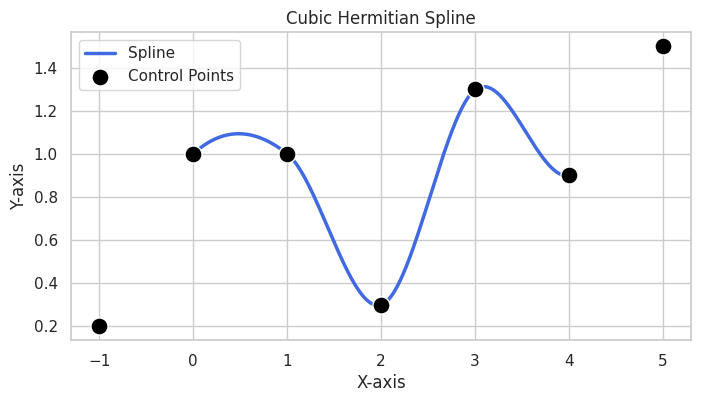

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x, y=spline, ax=ax, color=color_line_1, linewidth=2.5, label='Spline')

# Add a dot plot on top of the spline
sns.scatterplot(x=x_param, y=parameters, ax=ax, color=color_scatter_1, s=150, label='Control Points', zorder=5)

# Add titles and labels
ax.set_title("Cubic Hermitian Spline", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/A/cubic_hermite_spline.pdf", bbox_inches='tight')
plt.show()


# Spline Fitting

In [5]:
import torch

# Example data
x_data = torch.tensor([0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.9, 1.0])  # 5 data points
y_data = torch.tensor([0.3, 0.0, 0.4, 0.7, 0.8, 0.6, 0.8, 1.0])  # Example target values

# Construct the design matrix X
X = torch.stack([x_data**3, x_data**2, x_data, torch.ones_like(x_data)], dim=1)

# Solve the normal equations (X^T X) beta = X^T Y
XtX = X.t().mm(X)  # X^T X
XtY = X.t().mm(y_data.unsqueeze(1))  # X^T Y

# Compute the coefficients
a, b, c, d = torch.linalg.solve(XtX, XtY).squeeze()

# Define a cubic function (example with a, b, c, d as parameters)
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d


steps = 100

x_pred = torch.linspace(start=x_data[0], end=x_data[-1], steps=steps)
# print(x)

y_pred = cubic_function(x_pred, a, b, c, d)



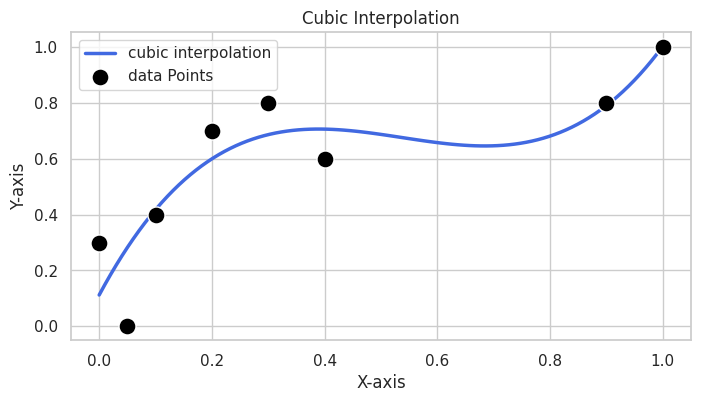

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_pred, y=y_pred, ax=ax, color=color_line_1, linewidth=2.5, label='cubic interpolation')

# Add a dot plot on top of the spline
sns.scatterplot(x=x_data, y=y_data, ax=ax, color=color_scatter_1, s=150, label='data Points', zorder=5)

# Add titles and labels
ax.set_title("Cubic Interpolation", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/A/cubic_interpolation.pdf", bbox_inches='tight')
plt.show()


# Spline fitting with constraints

In [7]:
import torch

# Construct the design matrix X
x_data_p = x_data[1:]
y_data_p = y_data[1:] - y_data[0]


X = torch.stack([x_data_p**3, x_data_p**2, x_data_p], dim=1)

# Solve the normal equations (X^T X) beta = X^T Y
XtX = X.t().mm(X)  # X^T X
XtY = X.t().mm(y_data_p.unsqueeze(1))  # X^T Y

# Compute the coefficients
a, b, c = torch.linalg.solve(XtX, XtY).squeeze()
d = y_data[0]

# Define a cubic function (example with a, b, c, d as parameters)
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d


steps = 100

x_pred_constraint = torch.linspace(start=x_data[0], end=x_data[-1], steps=steps)
# print(x)

y_pred_constraint = cubic_function(x_pred_constraint, a, b, c, d)



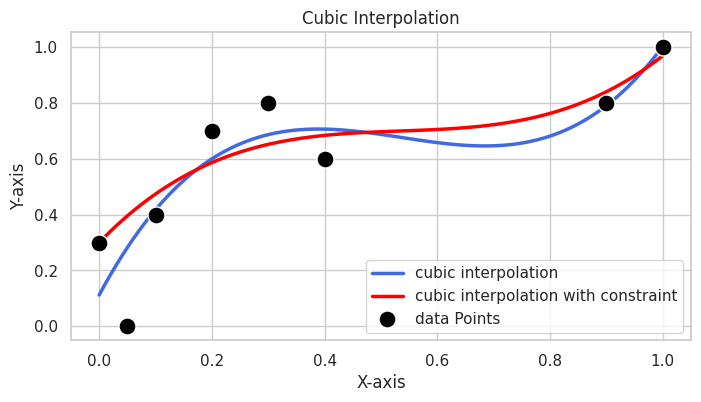

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_pred, y=y_pred, ax=ax, color=color_line_1, linewidth=2.5, label='cubic interpolation')

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_pred_constraint, y=y_pred_constraint, ax=ax, color=color_line_2, linewidth=2.5, label='cubic interpolation with constraint')

# Add a dot plot on top of the spline
sns.scatterplot(x=x_data, y=y_data, ax=ax, color=color_scatter_1, s=150, label='data Points', zorder=5)

# Add titles and labels
ax.set_title("Cubic Interpolation", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/A/cubic_interpolation_with_constaint.pdf", bbox_inches='tight')
plt.show()


# Bezier Curve

In [18]:
import torch

start = 0
stop = 1
steps=100

t = torch.linspace(start=start, end=stop, steps=steps*(stop-start))
# print(t)

cp0 = torch.tensor((0.0, 0.0))
cp1 = torch.tensor((0.0, 1.0))
cp2 = torch.tensor((1.0, 1.0))
cp3 = torch.tensor((1.0, 0.0))


def bezier_curve_deg_3(t, cp0, cp1, cp2, cp3):
    return cp0*((1-t)**3) + 3*cp1*t*((1-t)**2) + 3*cp2*(t**2)*(1-t) + cp3*(t**3)

x = bezier_curve_deg_3(t, cp0[0], cp1[0], cp2[0], cp3[0])
y = bezier_curve_deg_3(t, cp0[1], cp1[1], cp2[1], cp3[1])


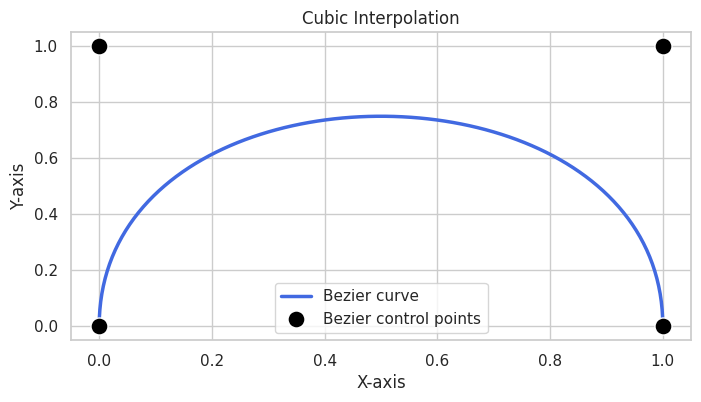

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x, y=y, ax=ax, color=color_line_1, linewidth=2.5, label='Bezier curve')


# Add a dot plot on top of the spline
sns.scatterplot(x=torch.stack((cp0[0], cp1[0], cp2[0], cp3[0])), y=torch.stack((cp0[1], cp1[1], cp2[1], cp3[1])), ax=ax, color=color_scatter_1, s=150, label='Bezier control points', zorder=5)

# Add titles and labels
ax.set_title("Cubic Interpolation", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
# plt.savefig("thesis image/B/bezier_curve.pdf", bbox_inches='tight')
plt.show()
